# 準備

In [1]:
import logging
import warnings

import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
dtype = torch.float16
seed = 42

warnings.simplefilter("ignore", FutureWarning)

# error ログのみを表示する
logger_name = "diffusers.pipelines.pipeline_utils"
logging.getLogger(logger_name).setLevel(logging.ERROR)

# Stable Diffusion 3 による画像生成

- 参考: https://hf.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_3

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
from diffusers import StableDiffusion3Pipeline

model_id = "stabilityai/stable-diffusion-3-medium-diffusers"

pipe = StableDiffusion3Pipeline.from_pretrained(
    model_id, torch_dtype=dtype
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
prompt = (
    "a photo of a cat holding a sign that says hello world"
)
negative_prompt = ""

num_inference_steps = 28
width, height = 1024, 1024
guidance_scale = 7.0

  0%|          | 0/28 [00:00<?, ?it/s]

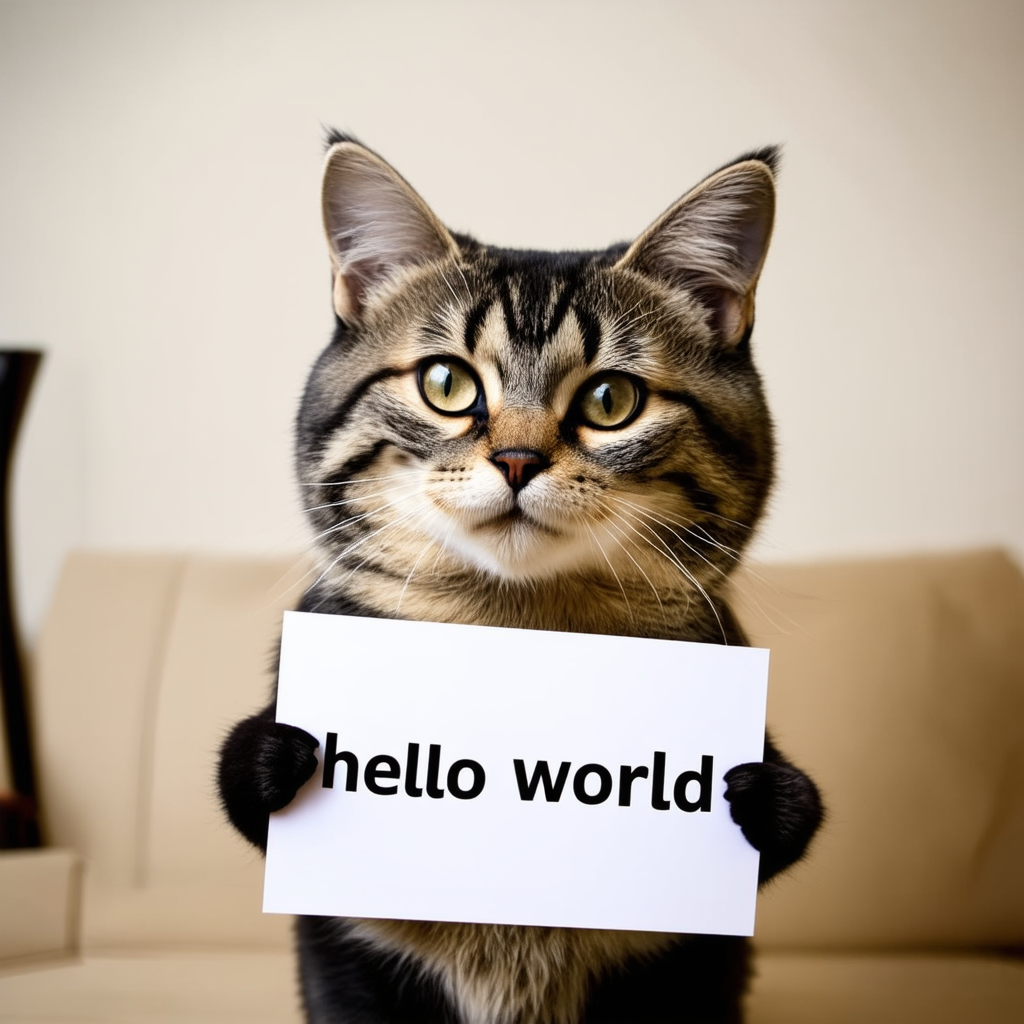

In [5]:
output = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    width=width,
    height=height,
    guidance_scale=guidance_scale,
    generator=torch.manual_seed(seed),
)
image = output.images[0]
image

In [6]:
import gc

pipe = pipe.to("cpu")
del pipe
gc.collect()
torch.cuda.empty_cache()

## Memory Optimisations for SD3

### Running Inference with Model Offloading

In [7]:
pipe_offload = StableDiffusion3Pipeline.from_pretrained(
    model_id, torch_dtype=dtype
)
pipe_offload.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

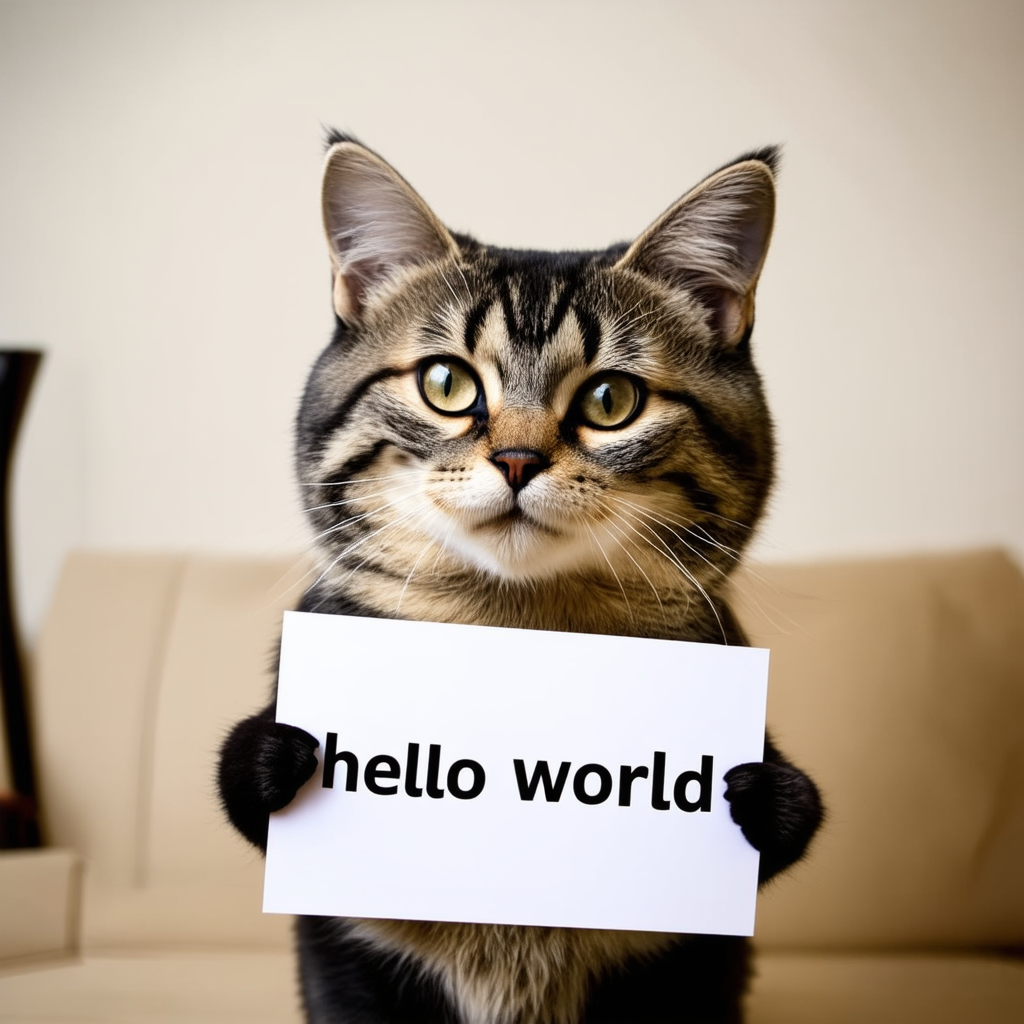

In [8]:
output = pipe_offload(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    width=width,
    height=height,
    guidance_scale=guidance_scale,
    generator=torch.manual_seed(seed),
)
image_offload = output.images[0]
image_offload

In [9]:
pipe_offload = pipe_offload.to("cpu")
del pipe_offload
gc.collect()
torch.cuda.empty_cache()

### Dropping the T5 Text Encoder during Inference

In [10]:
pipe_wo_t5 = StableDiffusion3Pipeline.from_pretrained(
    model_id,
    text_encoder_3=None,
    tokenizer_3=None,
    torch_dtype=dtype,
)
pipe_wo_t5 = pipe_wo_t5.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

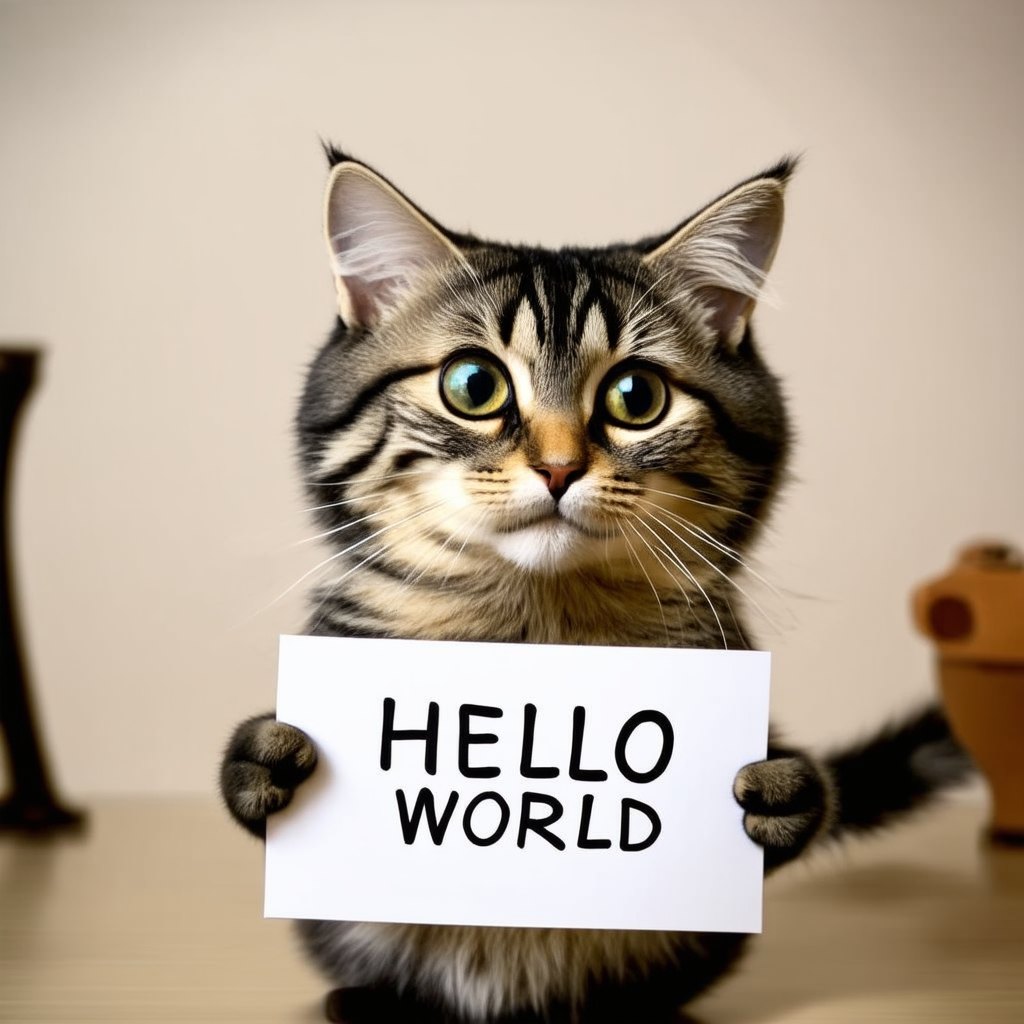

In [11]:
output = pipe_wo_t5(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    width=width,
    height=height,
    guidance_scale=guidance_scale,
    generator=torch.manual_seed(seed),
)
image_wo_t5 = output.images[0]
image_wo_t5

In [12]:
pipe_wo_t5 = pipe_wo_t5.to("cpu")
del pipe_wo_t5
gc.collect()
torch.cuda.empty_cache()

### Using a Quantized Version of the T5 Text Encoder

In [13]:
from transformers import BitsAndBytesConfig, T5EncoderModel

quantization_config = BitsAndBytesConfig(load_in_8bit=True)

text_encoder_quantized = T5EncoderModel.from_pretrained(
    model_id,
    subfolder="text_encoder_3",
    quantization_config=quantization_config,
)
pipe_quantized_t5 = (
    StableDiffusion3Pipeline.from_pretrained(
        model_id,
        text_encoder_3=text_encoder_quantized,
        device_map="balanced",
        torch_dtype=dtype,
    )
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

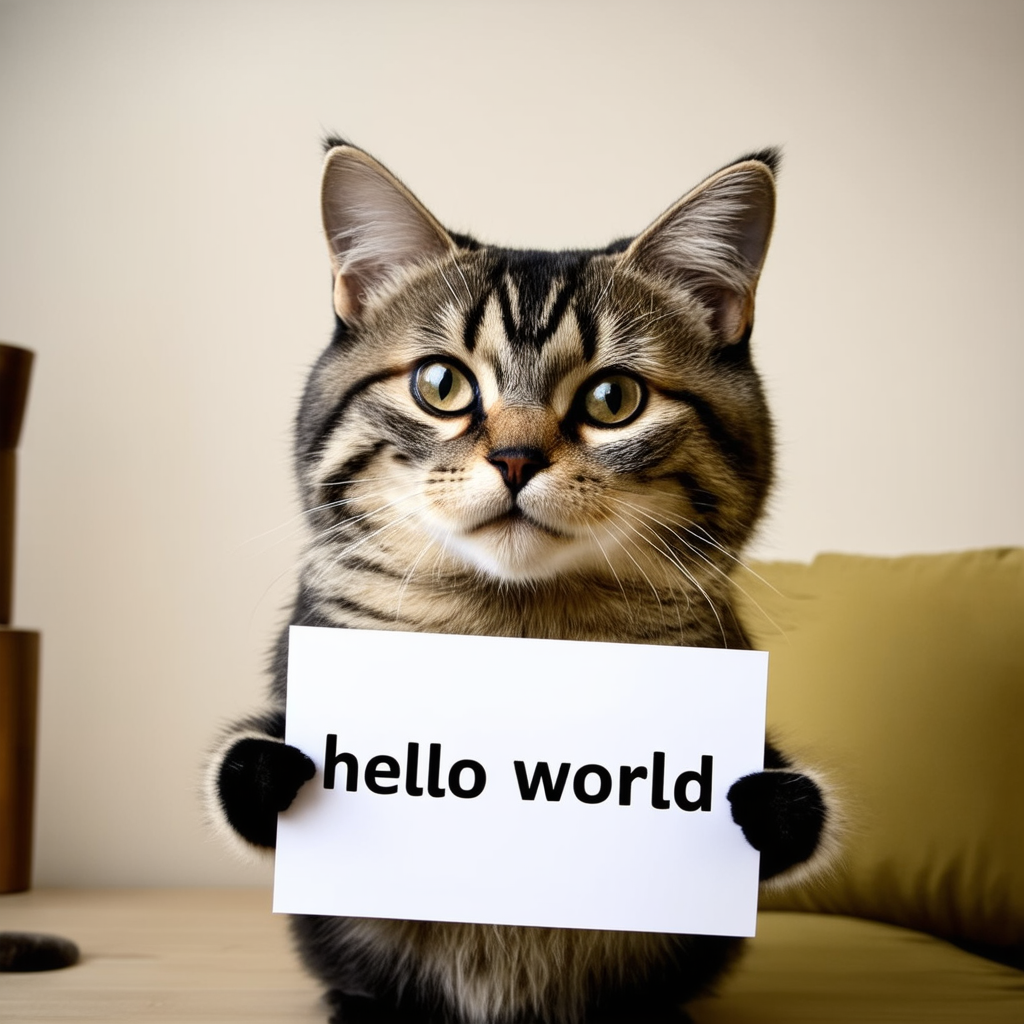

In [14]:
output = pipe_quantized_t5(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    width=width,
    height=height,
    guidance_scale=guidance_scale,
    generator=torch.manual_seed(seed),
)
image_quantized_t5 = output.images[0]
image_quantized_t5

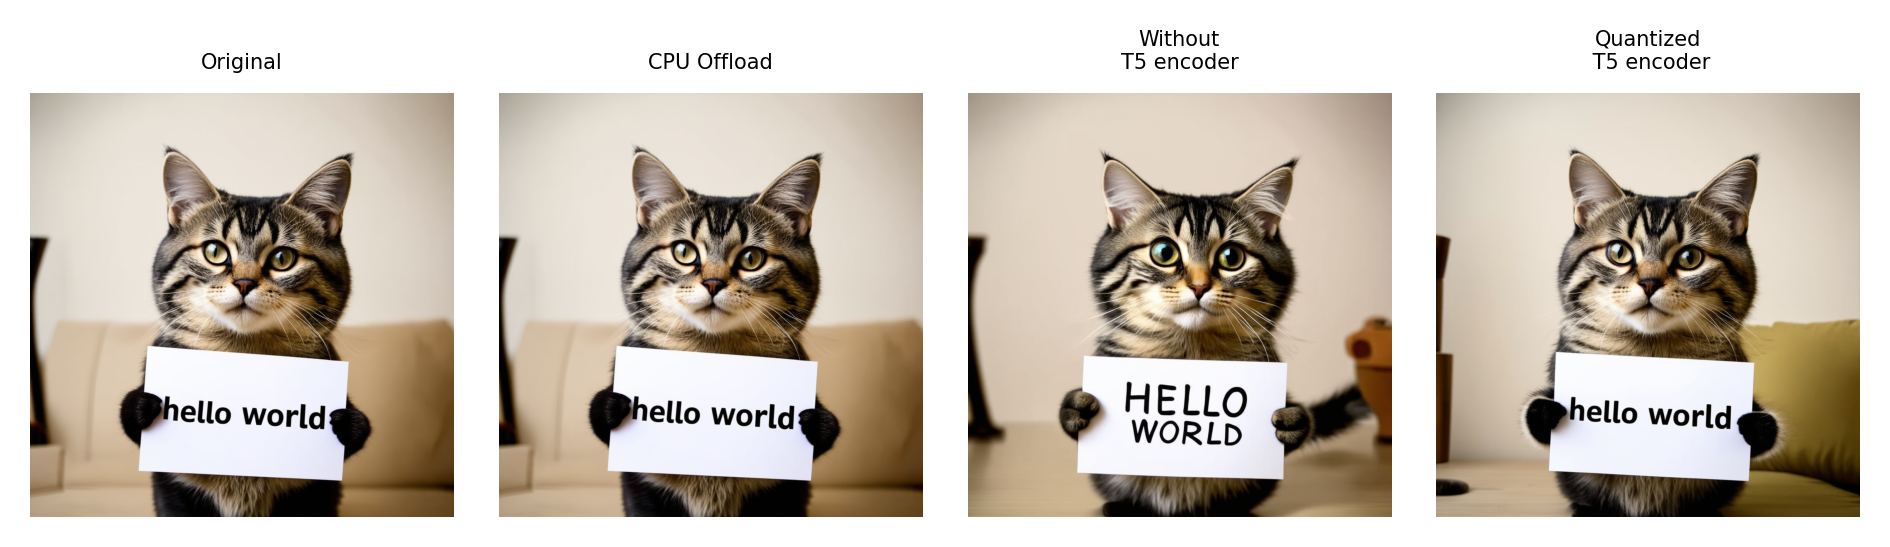

In [15]:
import matplotlib.pyplot as plt

images = {
    "Original": image,
    "CPU Offload": image_offload,
    "Without\nT5 encoder": image_wo_t5,
    "Quantized\n T5 encoder": image_quantized_t5,
}

fig, axes = plt.subplots(
    nrows=1, ncols=len(images), dpi=300
)

for i, (k, image) in enumerate(images.items()):
    axes[i].imshow(image)
    axes[i].set_title(k, fontsize=5)
    axes[i].axis("off")

fig.tight_layout()